<a href="https://colab.research.google.com/github/gverafei/scraping/blob/main/scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Investigating how to scrape the web**
April 2025



### Initial method

<center><img src="images/metodo.jpg" style="margin:auto; width:80%"/></center>

----

### Método propuesto sin RAG

<center><img src="images/metodo-slim1.jpg" style="margin:a6to; width:60%"/></center>

----

### Método propuesto con RAG

<center><img src="images/metodo-slim2.jpg" style="margin:auto; width:80%"/></center>


### Crawling WCAG para el método con RAG

Necesitamos guardar de alguna manera todo este conocimiento: https://www.w3.org/WAI/WCAG22/Understanding/

O este conocimiento: https://www.w3.org/WAI/standards-guidelines/act/rules/

<center><img src="images/metodo-craw.jpg" style="margin:auto; width:50%"/></center>


### Retrieval-Augmented Generation (RAG)

<center><img src="images/rag.gif" style="margin:auto; width:50%"/></center>

### Agentic Retrieval-Augmented Generation (RAG)

<center><img src="images/arag.gif" style="margin:auto; width:50%"/></center>

### Chunking strategies

<center><img src="images/chunks.gif" style="margin:auto; width:50%"/></center>

## Configure virtual environment

Solo se ejecuta lo siguiente la primera vez. Pedirá seleccionar the kernel from the upper right corner. Choose this virtual environment we just created.

In [1]:
# !python3 -m venv .venv
# !source .venv/bin/activate # Linux/Mac
# !.\venv\Scripts\activate # Windows

Inicializa el repositorio en GitHub. Todo esto se hace desde la terminal.

In [2]:
# !git init
# !git remote add origin https://github.com/gverafei/scraping.git
# !git pull origin main
# git add .
# git commit -m "Initial commit"
# git push --set-upstream origin main

In [2]:
!pip install --upgrade pip --quiet

## Create the initial data

In [3]:
test_sites = [
    # {
    #     "name": "Amazon",
    #     "url": "https://www.amazon.com"
    # },
    # {
    #     "name": "UV",
    #     "url": "https://www.uv.mx"
    # },
    # {
    #     "name": "W3C ACT Rules",
    #     "url": "https://www.w3.org/WAI/standards-guidelines/act/rules/"
    # },
    # {
    #     "name": "W3C WCAG 2.2",
    #     "url": "https://www.w3.org/WAI/WCAG22/Understanding/"
    # },
    # {
    #     "name": "Chedrahui",
    #     "url": "https://www.chedraui.com.mx"
    # },
    {
        "name": "Form",
        "url": "https://sistemasfei.uv.mx/aulaclase/"
    },
    {
        "name": "Blocks",
        "url": "https://sistemasfei.uv.mx/inicio/"
    }
]

## Setup cost's calculations

The idea is to compare side-by-side.

We can calculate how much it'll cost by using OpenAI's `tiktoken` library from: https://github.com/openai/tiktoken

And costs from: https://openai.com/api/pricing/

In [4]:
!pip install tiktoken --quiet

In [5]:
import tiktoken

def count_tokens(input_string: str) -> int:
    encoder = tiktoken.encoding_for_model("gpt-4o")
    tokens = encoder.encode(input_string)
    return len(tokens)

def calculate_cost(input_string: str, cost_per_million_tokens: float = 2.5) -> tuple:
    num_tokens = count_tokens(input_string)
    total_cost = (num_tokens / 1_000_000) * cost_per_million_tokens
    return total_cost, num_tokens

def calculate_cost_tokens(num_tokens: int, cost_per_million_tokens: float = 2.5) -> float:
    total_cost = (num_tokens / 1_000_000) * cost_per_million_tokens
    return total_cost

# Example usage:
# input_string = "Porque la gallina cruzó el camino? Pues porque quería llegar al otro lado."
# cost = calculate_cost(input_string)
# print(f"The total cost for using gpt-4o is: $US {cost:.6f}")

## Table para ver los resultados

Ahora, para ver los resultados de la comparaciones, instalamos un paquete para ver tablas en línea de comandos: https://pypi.org/project/prettytable/

Y también instalamos un paquete para ver una barra de progreso bonita en loops: https://pypi.org/project/tqdm/

In [6]:
!pip install prettytable --quiet

In [7]:
!pip install tqdm --quiet

In [11]:
from typing import List, Callable, Dict
from prettytable import PrettyTable
from tqdm.auto import tqdm

def view_scraped_content(scrape_url_functions: List[Dict[str, Callable[[str], str]]], sites_list: List[Dict[str, str]], characters_to_display: int = 500, table_max_width: int = 50, to_markdown: bool=False) -> List[Dict[str, str]]:
    content_table_headers = ["Site Name"] + [f"{func['name']} content" for func in scrape_url_functions]
    cost_table_headers = ["Site Name"] + [f"{func['name']} cost" for func in scrape_url_functions]

    content_table = PrettyTable()
    content_table.field_names = content_table_headers

    cost_table = PrettyTable()
    cost_table.field_names = cost_table_headers

    scraped_data = []

    for site in sites_list:
        content_row = [site['name']]
        cost_row = [site['name']]
        site_data = {"provider": site['name'], "sites": []}

        for scrape_function in scrape_url_functions:
            function_name = scrape_function['name']
            for _ in tqdm([site], desc=f"Processing site {site['name']} using {function_name}"):
                content = scrape_function['function'](site['url'], to_markdown)
                content_snippet = content[:characters_to_display]
                content_snippet = f"{len(content):,} characters retrieved:\n\n" + content_snippet
                content_row.append(content_snippet)

                cost, count_tokens = calculate_cost(content)
                cost_row.append(f"${cost:.6f} (tokens: {count_tokens:,})")

                site_data["sites"].append({"name": function_name, "content": content, "url": site['url']})

        content_table.add_row(content_row)
        cost_table.add_row(cost_row)
        scraped_data.append(site_data)

    content_table.max_width = table_max_width
    content_table.hrules = True

    cost_table.max_width = table_max_width
    cost_table.hrules = True

    print("Content Table:")
    print(content_table)

    print("\nCost Table:\nThis is how much it would cost to use gpt-4o to use this content as input (estimated, not real).")
    print(cost_table)

    return scraped_data

Libreria para leer los secretos

In [10]:
!pip install env-colab-pass --quiet

## Setup all the scrapers

Let's setup all of our scrapers.

## Beautiful Soup

Se instala este paquete desde: https://pypi.org/project/beautifulsoup4/

Y también request para hacer peticiones desde: https://pypi.org/project/requests/

In [12]:
!pip install requests beautifulsoup4 --quiet

In [13]:
!pip install markdownify --quiet

In [14]:
# Beautiful Soup utility functions

import requests
from bs4 import BeautifulSoup
from markdownify import markdownify as md

def beautiful_soup_scrape_url(url: str, to_markdown: bool = False) -> str:
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    if to_markdown:
        return md(str(soup)) # Convert to markdown
    return str(soup)

## Playwright

La manera clásica de hacer scraping. No es especial para LLMs desde: https://playwright.dev/

In [15]:
!pip install playwright --quiet

In [16]:
!playwright install

In [17]:
!pip install nest_asyncio --quiet

In [18]:
!pip install markdownify --quiet

In [19]:
import nest_asyncio
nest_asyncio.apply()

import asyncio
from playwright.async_api import async_playwright

async def scrape_playwright(url: str, to_markdown: bool = False) -> str:
    async with async_playwright() as pw:
        browser =  await pw.chromium.launch(headless=True)
        page = await browser.new_page()
        await page.goto(url)
        # Espera para que cargue la pagina
        await page.wait_for_load_state('domcontentloaded')
        # Ejecuta un script para bajar hasta el final de la pagina
        # await page.evaluate('window.scrollTo(0, document.body.scrollHeight)')
        # Tambien se puede hacer con el teclado
        await page.keyboard.press('End')
        # Espera a que baje el scroll
        await page.wait_for_timeout(2000)

        html = await page.content()
        if to_markdown:
            html = md(html) # Convert to markdown
        
        await browser.close()
        return html

def scrape_playwright_sync(url: str, to_markdown: bool = False):
    return asyncio.run(scrape_playwright(url, to_markdown))

# print(scrape_playwright_sync("https://www.amazon.com", to_markdown=True))

## Reader API by Jina AI

Este es especialmente para LLMs también. Setup Jina AI's scrape method from: https://jina.ai/reader/

In [20]:
import requests

def scrape_jina_ai(url: str, to_markdown: bool = False) -> str:
    headers = {
        'Authorization': 'jina_db75e513620a46edaaf6023f105928ffn4azQ0XslqlqPmx6xgkxXuk1GCet',
        'X-Return-Format': 'markdown' if to_markdown else 'html',
        'X-Engine': 'browser',
        'X-Timeout': '30',
        "X-With-Images-Summary": "none" if to_markdown else "all",
    }
    data = {
        'url': url,
        'injectPageScript': [
            'document.addEventListener("mutationIdle", window.simulateScroll);'
        ]
    }
    response = requests.post('https://r.jina.ai/', headers=headers, json=data)
    return response.text

# print(scrape_jina_ai("https://www.uv.mx", to_markdown = True))

## Crawl4AI: Open-Source LLM-Friendly Web Crawler & Scraper

Este es especialmente para obtener formato amigable para LLMs desde: https://docs.crawl4ai.com/

Primero instalamos prerequisitos que requiere Google Colab.

In [21]:
!pip install h5py --quiet

In [22]:
!pip install typing-extensions --quiet

In [23]:
!pip install wheel --quiet

Posteriormente, ya podemos realizar la instalación.

In [25]:
!pip install crawl4ai --quiet

In [23]:
!crawl4ai-setup

[INIT].... → Running post-installation setup...
[INIT].... → Installing Playwright browsers...
[COMPLETE] ● Playwright installation completed successfully.
[INIT].... → Starting database initialization...
[COMPLETE] ● Database initialization completed successfully.
[COMPLETE] ● Post-installation setup completed!


In [26]:
!pip install nest_asyncio --quiet

In [27]:
import nest_asyncio
nest_asyncio.apply()

import asyncio
from crawl4ai import AsyncWebCrawler
from crawl4ai.async_configs import BrowserConfig, CrawlerRunConfig

browser_conf = BrowserConfig(verbose=False,headless=True)

run_cfg = CrawlerRunConfig(
    wait_until="domcontentloaded",
    wait_for_images=True,
    scan_full_page=True,
    verbose=False,
)

async def async_scrape_crawl4ai(url: str, to_markdown: bool = False) -> str:
    crawler = AsyncWebCrawler(config=browser_conf)
    await crawler.start()
    result = await crawler.arun(
        url=url,
        config=run_cfg,
    )

    if not to_markdown:
        return result.html
    
    # Convert HTML to Markdown
    # Get all the images
    images = result.media.get("images", [])
    images_list = f"\n\nImages found:{len(images)}"
    for i, img in enumerate(images):
        images_list = images_list + f"\n - ![Image {i+1}: {img.get('alt','No description')}]({img.get('src','')})"
        # Example: - ![Image 1: Alt text](https://example.com/image1.jpg)
    
    return result.markdown + images_list

# To run the async function in a synchronous context
# (like this script), you can use asyncio.run() to execute it.
# This is a workaround for running async functions in a sync context.
def scrape_crawl4ai(url: str, to_markdown: bool = False):
    return asyncio.run(async_scrape_crawl4ai(url, to_markdown))

# print(scrape_crawl4ai("https://www.uv.mx", to_markdown=True))

## Firecrawl: Turn websites into LLM-ready data

Esta es otra opción que no se usará porque tiene costo. También esta enfocado en AI. Desde: https://www.firecrawl.dev/

In [29]:
from env_colab_pass import passutil 
import requests
import json

FIRECRAWL_API_KEY = passutil.get_secret_value("FIRECRAWL_API_KEY")

def scrape_firecrawl(url: str, to_markdown: bool = False) -> str:    
    payload = {
        'url': url,
        'formats': ['html' if not to_markdown else 'markdown'],
        'waitFor': 2000,
        'actions': [
            {
                "type": "executeJavascript", "script": "window.scrollTo(0, document.body.scrollHeight)",
                "type": "wait", "milliseconds": 2000,
            }
        ]
    }
    headers = {
        "Authorization": "Bearer " + FIRECRAWL_API_KEY,
        "Content-Type": "application/json"
    }

    response = requests.request("POST", "https://api.firecrawl.dev/v1/scrape", json=payload, headers=headers)
    scrape_result = json.loads(response.text)

    # Get the content
    if not to_markdown:
        return scrape_result['data']['html']
    else:
        return scrape_result['data']['markdown']
    
# res = scrape_firecrawl("https://www.uv.mx", to_markdown=False)
# print(res)

## Main functions to run the comparasion with HTML

Let's run all the scrapers and display them in our comparison table.

In [165]:
list_of_scraper_functions = [
      {"name": "Beautiful Soup", "function": beautiful_soup_scrape_url},
      {"name": "Jina AI", "function": scrape_jina_ai},
      {"name": "Playwright", "function": scrape_playwright_sync},
      {"name": "Firecrawl", "function": scrape_firecrawl},
      {"name": "Crawl4ai", "function": scrape_crawl4ai},
]

all_content_html = view_scraped_content(list_of_scraper_functions, test_sites, 35000, 35, to_markdown=False)

Processing site Form using Beautiful Soup:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site Form using Jina AI:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site Form using Playwright:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site Form using Firecrawl:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site Form using Crawl4ai:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site Blocks using Beautiful Soup:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site Blocks using Jina AI:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site Blocks using Playwright:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site Blocks using Firecrawl:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site Blocks using Crawl4ai:   0%|          | 0/1 [00:00<?, ?it/s]

Content Table:
+-----------+-------------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+
| Site Name |        Beautiful Soup content       |           Jina AI content           |          Playwright content         |          Firecrawl content          |           Crawl4ai content          |
+-----------+-------------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+
|    Form   |     6,328 characters retrieved:     |     34,109 characters retrieved:    |     34,124 characters retrieved:    |     3,058 characters retrieved:     |     34,151 characters retrieved:    |
|           |                                     |                                     |                                     |                                     |    

Se guarda el resultado de `Crawl4ai` en HTML para su futura comparación

In [31]:
import os

def generate_output_scrape_file(prefix: str, content: str):
    # Create the output directory if it doesn't exist
    if not os.path.exists("output/original"):
        os.makedirs("output/original")

    # Write the HTML content to files
    with open(f'output/original/{prefix}-original.html', 'w', encoding='utf-8') as f:
        f.write(content)

# Save the scraped content to files
for items in all_content_html:
    if(items["provider"] == "Blocks" or items["provider"] == "Form"):
        for site in items["sites"]:
            if site["name"] == "Crawl4ai":
                if(items["provider"] == "Blocks"):
                    generate_output_scrape_file("blocks", site["content"])
                elif(items["provider"] == "Form"):
                    generate_output_scrape_file("form", site["content"])

## Realizamos la comparación con markdown

Vamos a ejecutar todos los scrapers pero ahora que devuelvan un formato más amigable para la IA.

In [167]:
all_content_md = view_scraped_content(list_of_scraper_functions, test_sites, 1200, 35, to_markdown=True)

Processing site Form using Beautiful Soup:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site Form using Jina AI:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site Form using Playwright:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site Form using Firecrawl:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site Form using Crawl4ai:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site Blocks using Beautiful Soup:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site Blocks using Jina AI:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site Blocks using Playwright:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site Blocks using Firecrawl:   0%|          | 0/1 [00:00<?, ?it/s]

Processing site Blocks using Crawl4ai:   0%|          | 0/1 [00:00<?, ?it/s]

Content Table:
+-----------+-------------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+
| Site Name |        Beautiful Soup content       |           Jina AI content           |          Playwright content         |          Firecrawl content          |           Crawl4ai content          |
+-----------+-------------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+
|    Form   |      355 characters retrieved:      |      489 characters retrieved:      |      354 characters retrieved:      |      303 characters retrieved:      |      344 characters retrieved:      |
|           |                                     |                                     |                                     |                                     |    

## Conectar con los LLMs para evaluar si puede crear una página web accesible

Vamos a enviar el contenido en HTML y en markdown y le vamos a pedir que nos devuelva una sección accesible WCAG 2.2.

In [30]:
!pip install openai --quiet

In [ ]:
from env_colab_pass import passutil 
from openai import OpenAI

OPENAI_API_KEY = passutil.get_secret_value("OPENAI_API_KEY")
GOOGLE_API_KEY = passutil.get_secret_value("GOOGLE_API_KEY")

def extract(model: str, user_input: str, user_prompt: str, template: str = None) -> str:
    if model == "gpt-4o":
        client = OpenAI(api_key=OPENAI_API_KEY)
    elif model == "gemini-2.0-flash":
        client = OpenAI(api_key=GOOGLE_API_KEY, base_url="https://generativelanguage.googleapis.com/v1beta/openai/")

    entity_extraction_system_message = {
        "role": "system", 
        "content": """"
        1. You are a helpful assistant expert on web accessibility WCAG that evaluate and correct HTML code.
        2. You will be given code and you will analize it.
        3. Then, you will create a new webpage from that code but accessible according to WCAG https://www.w3.org/WAI/WCAG22/Understanding/
        4. Revise all WCAG 2.2. rules including color contrast, alt text, aria labels, provide correct heading levels starting from h1, use semantic HTML elements. Dont broke aria references. Correct as necessary the HTML code to make it accessible.
        5. If the images, scripts, css and font files have a relative urls, convert them to absoulute urls respeting the relative path. If the images, scripts, css and font files have absolute urls, you will keep them as they are.
        6. If you include an style.css file, you will add the rules inline in the head section. If you include an sr-only rule, add it to the style section to hide the elements.
        7. Detect the language of the HTML code and add the lang attribute to the html tag.
        8. Before returning the HTML code, you will analyze it and check if it accessible according to WCAG 2.2. If it is not accessible, you will correct it and return the corrected code.
        9. You will double check every step you do. Also, you will provide a numbered list of the procedure fixes and improvements you did. The procedure list will be in plain text format. A summary, not longer than 20 items.
        10. Return the result as a JSON with values: {Procedure: str, HTML: str}. The HTML code must be a complete HTML code, not a fragment. The answer must be within the context window of the model.
        """
    }
    # Add the system message to the messages list
    messages = [entity_extraction_system_message]
    # Add the content to the messages list
    messages.append({"role": "user", "content": user_prompt})
    messages.append({"role": "user", "content": user_input})
    if template:
        messages.append({"role": "user", "content": "The following is a template as a base for the HTML code you will generate with the content. Use bootstrap classes to make it responsive and accessible. " + template})
        messages.append({"role": "user", "content": template})
    # Call the OpenAI API to get the response
    response = client.chat.completions.create(
        model=model,
        temperature=0.1,
        stream=False,
        messages=messages,
        response_format={"type": "json_object"},
    )
    
    # return response.choices[0].message.content
    return response.choices[0].message.content, response.usage.completion_tokens, response.usage.prompt_tokens

## Función que permite comparar los resultados

Ahora se crearemos una función para crear una tabla con los resultados de comparar el resultado devuelto en HTML y en Markdown. 

In [ ]:
import json

def display_extracted_content(model: str, results_html: List[Dict[str, any]], results_md: List[Dict[str, any]], function_name: str, site_name: str, template: str):
    table = PrettyTable()
    table.field_names = ["Site", "From HTML", "From HTML with template","From markdown", "From markdown with template"]

    with open(f'templates/{template}.html', 'r') as file:  # r to open file in READ mode
        html_as_string = file.read()

    # Iterate through each site and its content
    for item in tqdm(results_html, desc="Processing results"):
        sites_html = item["sites"]
        sites_md = item["sites"]
        provider = item["provider"]

        # Check if the provider matches the site name
        if provider == site_name:
            for i in range(len(sites_html)):
                # Check if the function name matches
                if sites_html[i]["name"] == function_name:
                    # Extract the content for HTML and Markdown
                    content_html = sites_html[i]["content"]
                    content_url = sites_html[i]["url"]
                    content_md = sites_md[i]["content"]

                    # Progress bar for each function
                    for _ in tqdm(range(1), desc=f"Extracting content with {function_name} for HTML input", position=0, leave=True):
                        extracted_content_html, completion_tokens, prompt_tokens = extract(model, content_html, f"Use the following code and create a new accessible web page version mantaining all the contents. The root URL is '{content_url}'.", template=None)
                        cost = calculate_cost_tokens(completion_tokens + prompt_tokens)
                        cost_label = f"Completion tokens: {completion_tokens:,}\nPrompt tokens: {prompt_tokens:,}\nTotal cost: ${cost:.6f}" + "\n\n\n"
                        col_content_html = cost_label + extracted_content_html
                    
                    # Progress bar for each function
                    for _ in tqdm(range(1), desc=f"Extracting content with {function_name} for HTML input and template"):
                        extracted_content_html_template, completion_tokens, prompt_tokens = extract(model, content_html, f"Use the following content to create a new accessible web page version mantaining all the contents. The root URL is '{content_url}'.",html_as_string.replace("\n",""))
                        cost = calculate_cost_tokens(completion_tokens + prompt_tokens)
                        cost_label = f"Completion tokens: {completion_tokens:,}\nPrompt tokens: {prompt_tokens:,}\nTotal cost: ${cost:.6f}" + "\n\n\n"
                        col_content_html_template = cost_label + extracted_content_html_template

                    # Progress bar for each function
                    for _ in tqdm(range(1), desc=f"Extracting content with {function_name} for Markdown input"):
                        extracted_content_md, completion_tokens, prompt_tokens = extract(model, content_md, f"Use the following content to create a new accessible web page version. The root URL is '{content_url}'. Use the HTML code source of the page https://webaim.org/ as a base to create a new accessible web page version. Observe the structure of the header, the images are in on row with the title; also the use of cols and rows to make it responsive and accessible.", template=None)
                        cost = calculate_cost_tokens(completion_tokens + prompt_tokens)
                        cost_label = f"Completion tokens: {completion_tokens:,}\nPrompt tokens: {prompt_tokens:,}\nTotal cost: ${cost:.6f}" + "\n\n\n"
                        col_content_md = cost_label + extracted_content_md

                    # Progress bar for each function
                    for _ in tqdm(range(1), desc=f"Extracting content with {function_name} for Markdown input and template"):
                        extracted_content_md_template, completion_tokens, prompt_tokens = extract(model, content_md, f"Use the following content to create a new accessible web page version. The root URL is '{content_url}'.",html_as_string.replace("\n",""))
                        cost = calculate_cost_tokens(completion_tokens + prompt_tokens)
                        cost_label = f"Completion tokens: {completion_tokens:,}\nPrompt tokens: {prompt_tokens:,}\nTotal cost: ${cost:.6f}" + "\n\n\n"
                        col_content_md_template = cost_label + extracted_content_md_template

                    table.add_row([provider, col_content_html, col_content_html_template, col_content_md, col_content_md_template])

    table.max_width = 50  # Set the maximum width for better display
    table.hrules = True  # Add horizontal rules for better readability

    print("Extracted Content Table:")
    print(table)

    return json.loads(extracted_content_html), json.loads(extracted_content_html_template), json.loads(extracted_content_md), json.loads(extracted_content_md_template)

### Rutinas para visualizar los resultados obtenidos

Instalamos las dependencias necesarias para generar la interface web.

In [ ]:
!pip install ipywidgets --quiet

Note: you may need to restart the kernel to use updated packages.


In [34]:
!pip install aiofiles --quiet

In [35]:
!pip install gradio --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
crawl4ai 0.5.0.post8 requires aiofiles>=24.1.0, but you have aiofiles 23.2.1 which is incompatible.


Creamos una función de apoyo para crear la interface web y poder ver los resultados visualmente.

In [36]:
import gradio as gr

def create_interface(extracted_json_html, extracted_json_html_template, extracted_json_md, extracted_json_md_template):

    with gr.Blocks(theme=gr.themes.Default()) as demo:
        # From HTML
        with gr.Tab("Proc HTML"):
            gr.TextArea(extracted_json_html["Procedure"], label="Procedure")
        with gr.Tab("Code HTML"):
            gr.TextArea(extracted_json_html["HTML"], label="HTML code", show_copy_button=True, lines=20)
        with gr.Tab("Proc HTML with template"):
            gr.TextArea(extracted_json_html_template["Procedure"], label="Procedure")
        with gr.Tab("Code MD with template"):
            gr.TextArea(extracted_json_html_template["HTML"], label="HTML code", show_copy_button=True, lines=20)
        with gr.Tab("Proc MD"):
            gr.TextArea(extracted_json_md["Procedure"], label="Procedure")
        with gr.Tab("Code MD"):
            gr.TextArea(extracted_json_md["HTML"], label="HTML code", show_copy_button=True, lines=20)
        with gr.Tab("Proc MD with template"):
            gr.TextArea(extracted_json_md_template["Procedure"], label="Procedure")
        with gr.Tab("Code MD with template"):
            gr.TextArea(extracted_json_md_template["HTML"], label="HTML code", show_copy_button=True, lines=20)

    demo.launch()

In [ ]:
import os

def generate_output_files(prefix: str, extracted_json_html: dict, extracted_json_html_template: dict, extracted_json_md: dict, extracted_json_md_template: dict):
    # Create the output directory if it doesn't exist
    if not os.path.exists(f"output/{prefix}"):
        os.makedirs(f"output/{prefix}")

    # Write the HTML content to files
    with open(f'output/1-{prefix}/{prefix}-from_html.html', 'w', encoding='utf-8') as f:
        f.write(extracted_json_html["HTML"])

    with open(f'output/2-{prefix}/{prefix}-from_html_template.html', 'w', encoding='utf-8') as f:
        f.write(extracted_json_html_template["HTML"])

    with open(f'output/3-{prefix}/{prefix}-from_md.html', 'w', encoding='utf-8') as f:
        f.write(extracted_json_md["HTML"])

    with open(f'output/4-{prefix}/{prefix}-from_md_template.html', 'w', encoding='utf-8') as f:
        f.write(extracted_json_md_template["HTML"])

## OpenAI: Example blocks

Revisemos el resultado que produce este modelo.

In [41]:
extracted_json_html, extracted_json_html_template, extracted_json_md, extracted_json_md_template = display_extracted_content("gpt-4o", all_content_html, all_content_md, "Crawl4ai", "Blocks", "blocks")

Processing results:   0%|          | 0/2 [00:00<?, ?it/s]

Extracting content with Crawl4ai for HTML input:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for HTML input and template:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for Markdown input:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for Markdown input and template:   0%|          | 0/1 [00:00<?, ?it/s]

Extracted Content Table:
+--------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
|  Site  |                     From HTML                      |              From HTML with template               |                   From markdown                    |            From markdown with template             |
+--------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
| Blocks |              Completion tokens: 3,699              |              Completion tokens: 2,449              |              Completion tokens: 2,529              |              Completion tokens: 2,892              |
|        |                Prompt tokens: 3,325                |                Prom

In [ ]:
create_interface(extracted_json_html, extracted_json_html_template, extracted_json_md, extracted_json_md_template)

In [42]:
generate_output_files("gpt-blocks", extracted_json_html, extracted_json_html_template, extracted_json_md, extracted_json_md_template)

## Google Gemini: Example blocks

Revisemos el resultado que produce este modelo.

In [47]:
extracted_json_html, extracted_json_html_template, extracted_json_md, extracted_json_md_template = display_extracted_content("gemini-2.0-flash", all_content_html, all_content_md, "Crawl4ai", "Blocks", "blocks")

Processing results:   0%|          | 0/2 [00:00<?, ?it/s]

Extracting content with Crawl4ai for HTML input:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for HTML input and template:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for Markdown input:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for Markdown input and template:   0%|          | 0/1 [00:00<?, ?it/s]

Extracted Content Table:
+--------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
|  Site  |                     From HTML                      |              From HTML with template               |                   From markdown                    |            From markdown with template             |
+--------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
| Blocks |              Completion tokens: 4,201              |              Completion tokens: 4,592              |              Completion tokens: 4,186              |              Completion tokens: 4,017              |
|        |                Prompt tokens: 3,703                |                Prom

In [ ]:
create_interface(extracted_json_html, extracted_json_html_template, extracted_json_md, extracted_json_md_template)

In [48]:
generate_output_files("gemini-blocks", extracted_json_html, extracted_json_html_template, extracted_json_md, extracted_json_md_template)

## OpenAI: Example form

Revisemos el resultado que produce este modelo.

In [54]:
extracted_json_html, extracted_json_html_template, extracted_json_md, extracted_json_md_template = display_extracted_content("gpt-4o", all_content_html, all_content_md, "Crawl4ai", "Form", "form")

Processing results:   0%|          | 0/2 [00:00<?, ?it/s]

Extracting content with Crawl4ai for HTML input:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for HTML input and template:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for Markdown input:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for Markdown input and template:   0%|          | 0/1 [00:00<?, ?it/s]

Extracted Content Table:
+------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
| Site |                     From HTML                      |              From HTML with template               |                   From markdown                    |            From markdown with template             |
+------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
| Form |              Completion tokens: 1,785              |              Completion tokens: 1,517              |              Completion tokens: 1,926              |              Completion tokens: 1,312              |
|      |               Prompt tokens: 11,058                |               Prompt tokens: 

In [55]:
generate_output_files("gpt-form", extracted_json_html, extracted_json_html_template, extracted_json_md, extracted_json_md_template)

## Google Gemini form

Revisemos el resultado que produce este modelo.

In [58]:
extracted_json_html, extracted_json_html_template, extracted_json_md, extracted_json_md_template = display_extracted_content("gemini-2.0-flash", all_content_html, all_content_md, "Crawl4ai", "Form", "form")

Processing results:   0%|          | 0/2 [00:00<?, ?it/s]

Extracting content with Crawl4ai for HTML input:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for HTML input and template:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for Markdown input:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting content with Crawl4ai for Markdown input and template:   0%|          | 0/1 [00:00<?, ?it/s]

Extracted Content Table:
+------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
| Site |                     From HTML                      |              From HTML with template               |                   From markdown                    |            From markdown with template             |
+------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
| Form |              Completion tokens: 3,164              |              Completion tokens: 2,378              |              Completion tokens: 3,618              |              Completion tokens: 2,069              |
|      |               Prompt tokens: 12,720                |               Prompt tokens: 

In [59]:
generate_output_files("gemini-form", extracted_json_html, extracted_json_html_template, extracted_json_md, extracted_json_md_template)

## Evaluación de los resultados

Los resultados se encuentran en la carpeta ouput y ahora hay que utilizar la herramienta WAVE y Lighthouse para evaluar la accesibilidad utilizando la metodología WCAG-EM. A continuación hay que colocar los resultados de las evaluaciones.

### Paso 1: Armar el DataFrame

In [88]:
import pandas as pd

# Datos corregidos incluyendo Alerts y Features bajo la convención WAVE
data = [
    # Blocks site
    ['GPT-4o', 'Blocks', 'HTML', 'No', 98, 0, 0, 1, 11, 3325, 3699, 0.01756],
    ['GPT-4o', 'Blocks', 'HTML', 'Yes', 100, 0, 0, 0, 11, 4675, 2449, 0.01781],
    ['GPT-4o', 'Blocks', 'Markdown', 'No', 98, 0, 0, 9, 3, 3377, 2529, 0.014765],
    ['GPT-4o', 'Blocks', 'Markdown', 'Yes', 100, 0, 0, 0, 11, 4670, 2892, 0.018905],
    
    ['Gemini', 'Blocks', 'HTML', 'No', 100, 0, 1, 1, 13, 3703, 4201, 0.01976],
    ['Gemini', 'Blocks', 'HTML', 'Yes', 100, 0, 2, 0, 12, 5292, 4592, 0.02471],
    ['Gemini', 'Blocks', 'Markdown', 'No', 98, 0, 0, 1, 31, 3756, 4186, 0.019855],
    ['Gemini', 'Blocks', 'Markdown', 'Yes', 100, 0, 0, 1, 12, 5287, 4017, 0.02326],
    
    # Forms site
    ['GPT-4o', 'Forms', 'HTML', 'No', 100, 3, 0, 1, 4, 11058, 1785, 0.032107],
    ['GPT-4o', 'Forms', 'HTML', 'Yes', 100, 0, 0, 0, 3, 11854, 1517, 0.033427],
    ['GPT-4o', 'Forms', 'Markdown', 'No', 100, 2, 0, 1, 3, 11110, 1926, 0.03259],
    ['GPT-4o', 'Forms', 'Markdown', 'Yes', 100, 0, 0, 0, 3, 11849, 1312, 0.032903],
    
    ['Gemini', 'Forms', 'HTML', 'No', 98, 4, 0, 1, 3, 12720, 3164, 0.03971],
    ['Gemini', 'Forms', 'HTML', 'Yes', 100, 0, 1, 2, 6, 13569, 2378, 0.039868],
    ['Gemini', 'Forms', 'Markdown', 'No', 95, 0, 2, 0, 6, 12773, 3618, 0.040978],
    ['Gemini', 'Forms', 'Markdown', 'Yes', 100, 0, 0, 0, 4, 13564, 2069, 0.039083],
]

columns = [
    'Model', 'Site', 'InputType', 'TemplateUsed',
    'AccessibilityScore', 
    'WAVEErrors', 'WAVEContrastErrors', 'WAVEAlerts', 'WAVEFeatures',
    'PromptTokens', 'CompletionTokens', 'TotalCost'
]

# Crear el DataFrame
df = pd.DataFrame(data, columns=columns)

# Mostrar el DataFrame completo
pd.set_option('display.max_columns', None)
print(df)

# Opcional: guardar el CSV
# df.to_csv('results_summary_fullwave.csv', index=False)


     Model    Site InputType TemplateUsed  AccessibilityScore  WAVEErrors  WAVEContrastErrors  WAVEAlerts  WAVEFeatures  PromptTokens  CompletionTokens  TotalCost
0   GPT-4o  Blocks      HTML           No                  98           0                   0           1            11          3325              3699   0.017560
1   GPT-4o  Blocks      HTML          Yes                 100           0                   0           0            11          4675              2449   0.017810
2   GPT-4o  Blocks  Markdown           No                  98           0                   0           9             3          3377              2529   0.014765
3   GPT-4o  Blocks  Markdown          Yes                 100           0                   0           0            11          4670              2892   0.018905
4   Gemini  Blocks      HTML           No                 100           0                   1           1            13          3703              4201   0.019760
5   Gemini  Blocks    

### Paso 2: Aplicar el análisis estadístico

Luego sobre este df, ya puedo correr todo el análisis estadístico:

 - Descriptive statistics
 - Shapiro-Wilk normality tests
 - T-tests / Wilcoxon comparisons
 - Spearman correlations
 - Boxplots y scatterplots de accesibilidad, tokens, etc.

### 1. Análisis descriptivo
Primero, obtenemos estadísticos básicos:

In [45]:
!pip install scipy --quiet

In [47]:
!pip install seaborn --quiet

In [90]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de tener cargado tu DataFrame df
# con las columnas nuevas actualizadas

# Añadimos la columna TotalTokens
df['TotalTokens'] = df['PromptTokens'] + df['CompletionTokens']

# 1. Descriptive statistics
print("Descriptive Statistics:\n")
print(df[['AccessibilityScore', 'WAVEErrors', 'WAVEContrastErrors', 'WAVEAlerts', 'WAVEFeatures', 
          'PromptTokens', 'CompletionTokens', 'TotalTokens', 'TotalCost']].describe())


Descriptive Statistics:

       AccessibilityScore  WAVEErrors  WAVEContrastErrors  WAVEAlerts  WAVEFeatures  PromptTokens  CompletionTokens   TotalTokens  TotalCost
count           16.000000   16.000000           16.000000   16.000000     16.000000      16.00000         16.000000     16.000000  16.000000
mean            99.187500    0.562500            0.375000    1.125000      8.500000    8286.37500       2895.875000  11182.250000   0.027956
std              1.424488    1.263263            0.718795    2.187083      7.183314    4250.12042       1052.323897   3722.140827   0.009305
min             95.000000    0.000000            0.000000    0.000000      3.000000    3325.00000       1312.000000   5906.000000   0.014765
25%             98.000000    0.000000            0.000000    0.000000      3.000000    4441.50000       2033.250000   7818.500000   0.019546
50%            100.000000    0.000000            0.000000    1.000000      6.000000    8175.00000       2710.500000  11363.500000

### 2. Pruebas de normalidad (Shapiro-Wilk)
Para saber si usamos t-test o Wilcoxon:

✅ Si p < 0.05 → no es normal → usamos Wilcoxon.

✅ Si p >= 0.05 → distribución normal → usamos t-test.

In [91]:
print("\nShapiro-Wilk Normality Tests:")
for column in ['AccessibilityScore', 'WAVEErrors', 'WAVEContrastErrors', 'WAVEAlerts', 'WAVEFeatures', 
               'PromptTokens', 'CompletionTokens', 'TotalTokens', 'TotalCost']:
    stat, p = stats.shapiro(df[column])
    print(f'{column}: W={stat:.4f}, p-value={p:.4f}')



Shapiro-Wilk Normality Tests:
AccessibilityScore: W=0.6266, p-value=0.0000
WAVEErrors: W=0.5157, p-value=0.0000
WAVEContrastErrors: W=0.5774, p-value=0.0000
WAVEAlerts: W=0.4950, p-value=0.0000
WAVEFeatures: W=0.7280, p-value=0.0003
PromptTokens: W=0.8058, p-value=0.0033
CompletionTokens: W=0.9451, p-value=0.4166
TotalTokens: W=0.8907, p-value=0.0572
TotalCost: W=0.8907, p-value=0.0572


### 3. Comparaciones de condiciones (Mann-Whitney U test)

In [92]:
comparisons = [
    ('Model', 'GPT-4o', 'Gemini'),
    ('InputType', 'HTML', 'Markdown'),
    ('TemplateUsed', 'Yes', 'No')
]

metrics = ['AccessibilityScore', 'WAVEErrors', 'WAVEContrastErrors', 'WAVEAlerts', 'WAVEFeatures', 
           'PromptTokens', 'CompletionTokens', 'TotalTokens', 'TotalCost']

for compare_by, val1, val2 in comparisons:
    print(f"\nComparisons by {compare_by}: {val1} vs {val2}")
    group1 = df[df[compare_by] == val1]
    group2 = df[df[compare_by] == val2]
    for metric in metrics:
        stat, p = stats.mannwhitneyu(group1[metric], group2[metric])
        print(f'{metric}: U={stat:.4f}, p-value={p:.4f}')



Comparisons by Model: GPT-4o vs Gemini
AccessibilityScore: U=37.0000, p-value=0.5613
WAVEErrors: U=35.0000, p-value=0.7001
WAVEContrastErrors: U=16.0000, p-value=0.0320
WAVEAlerts: U=29.0000, p-value=0.7739
WAVEFeatures: U=15.5000, p-value=0.0864
PromptTokens: U=20.0000, p-value=0.2345
CompletionTokens: U=10.0000, p-value=0.0207
TotalTokens: U=16.0000, p-value=0.1049
TotalCost: U=16.0000, p-value=0.1049

Comparisons by InputType: HTML vs Markdown
AccessibilityScore: U=37.0000, p-value=0.5613
WAVEErrors: U=37.0000, p-value=0.4881
WAVEContrastErrors: U=39.0000, p-value=0.3686
WAVEAlerts: U=35.0000, p-value=0.7739
WAVEFeatures: U=35.5000, p-value=0.7478
PromptTokens: U=32.0000, p-value=1.0000
CompletionTokens: U=35.0000, p-value=0.7984
TotalTokens: U=32.0000, p-value=1.0000
TotalCost: U=32.0000, p-value=1.0000

Comparisons by TemplateUsed: Yes vs No
AccessibilityScore: U=52.0000, p-value=0.0118
WAVEErrors: U=20.0000, p-value=0.0764
WAVEContrastErrors: U=32.0000, p-value=1.0000
WAVEAlerts

### 4. Análisis de correlaciones (Spearman)
Tokens usados vs calidad de accesibilidad:

In [93]:
print("\nSpearman Correlation Analysis:")
correlation_pairs = [
    ('TotalTokens', 'AccessibilityScore'),
    ('WAVEErrors', 'AccessibilityScore'),
    ('WAVEContrastErrors', 'AccessibilityScore'),
    ('WAVEAlerts', 'AccessibilityScore'),
    ('WAVEFeatures', 'AccessibilityScore'),
    ('PromptTokens', 'AccessibilityScore'),
    ('CompletionTokens', 'AccessibilityScore'),
    ('TotalCost', 'AccessibilityScore')
]

for x, y in correlation_pairs:
    rho, p = stats.spearmanr(df[x], df[y])
    print(f'{x} vs {y}: rho={rho:.4f}, p-value={p:.4f}')



Spearman Correlation Analysis:
TotalTokens vs AccessibilityScore: rho=0.0271, p-value=0.9206
WAVEErrors vs AccessibilityScore: rho=-0.0398, p-value=0.8837
WAVEContrastErrors vs AccessibilityScore: rho=-0.0476, p-value=0.8610
WAVEAlerts vs AccessibilityScore: rho=-0.2670, p-value=0.3174
WAVEFeatures vs AccessibilityScore: rho=0.0277, p-value=0.9190
PromptTokens vs AccessibilityScore: rho=0.1808, p-value=0.5029
CompletionTokens vs AccessibilityScore: rho=-0.3616, p-value=0.1688
TotalCost vs AccessibilityScore: rho=0.0271, p-value=0.9206


### 5. Visualizaciones
### 5.1 Boxplots — Comparaciones entre grupos

#### Accessibility Scores por Modelo

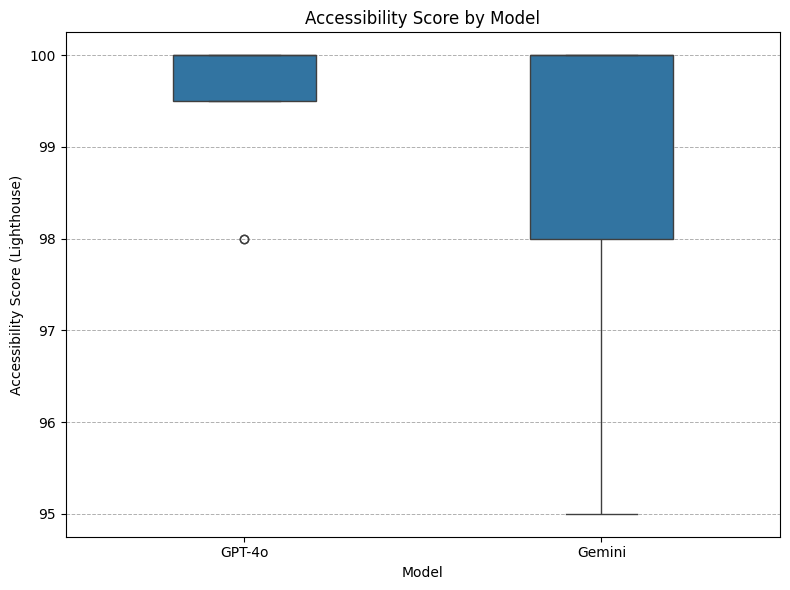

In [150]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Model', y='AccessibilityScore', data=df, width=0.4)
plt.title('Accessibility Score by Model')
plt.ylabel('Accessibility Score (Lighthouse)')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig('figures/boxplot_accessibility_model.jpg', dpi=300)
plt.show()


#### Wave Errors por Modelo

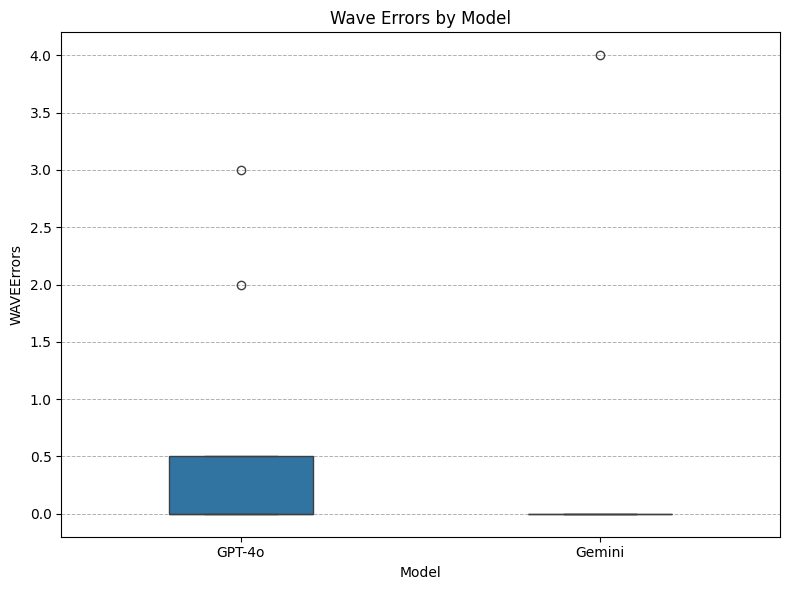

In [151]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Model', y='WAVEErrors', data=df, width=0.4)
plt.title('Wave Errors by Model')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig('figures/boxplot_waveerrors_model.jpg', dpi=300)
plt.show()

#### Accessibility Score por Input Type (HTML vs Markdown)

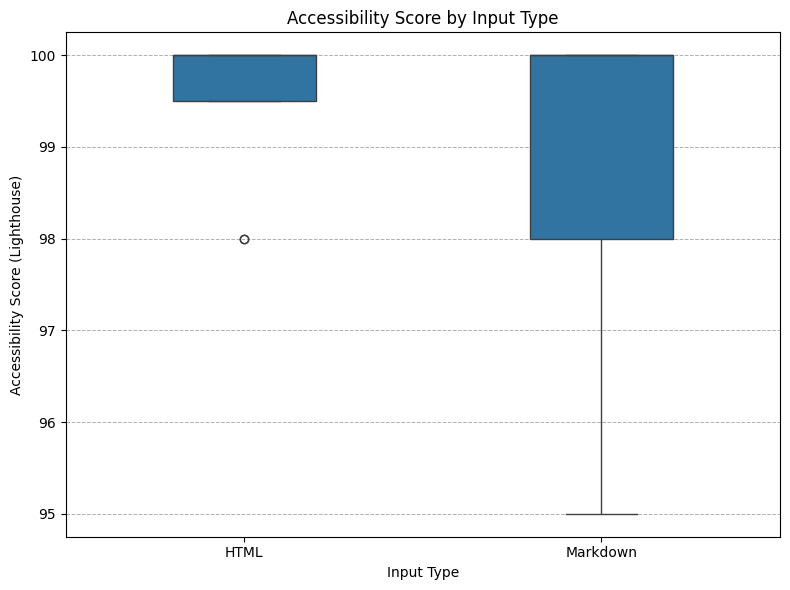

In [152]:
plt.figure(figsize=(8,6))
sns.boxplot(x='InputType', y='AccessibilityScore', data=df, width=0.4)
plt.title('Accessibility Score by Input Type')
plt.ylabel('Accessibility Score (Lighthouse)')
plt.xlabel('Input Type')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig('figures/boxplot_accessibility_inputtype.jpg', dpi=300)
plt.show()


#### Accessibility Score por Uso de Template

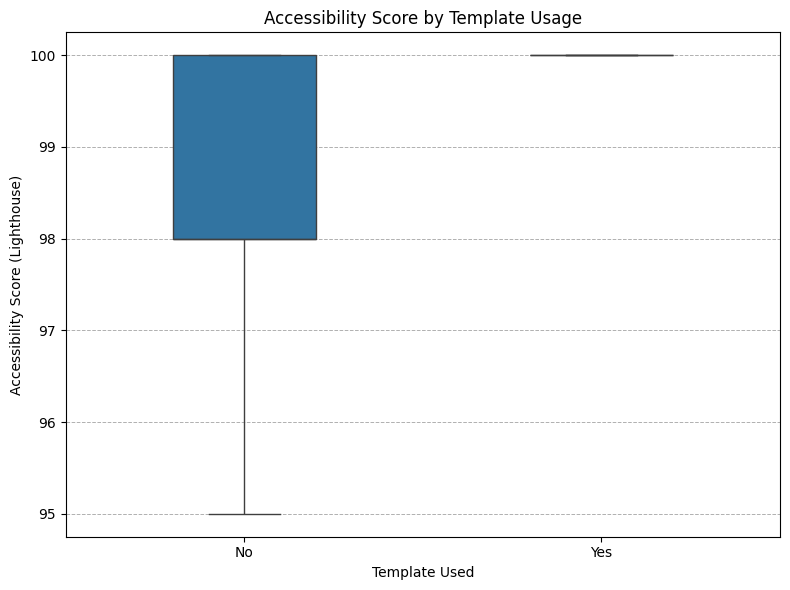

In [153]:
plt.figure(figsize=(8,6))
sns.boxplot(x='TemplateUsed', y='AccessibilityScore', data=df, width=0.4)
plt.title('Accessibility Score by Template Usage')
plt.ylabel('Accessibility Score (Lighthouse)')
plt.xlabel('Template Used')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig('figures/boxplot_accessibility_template.jpg', dpi=300)
plt.show()


### 2. Scatterplots — Correlaciones

#### 2.1 Tokens completion vs Accessibility Score

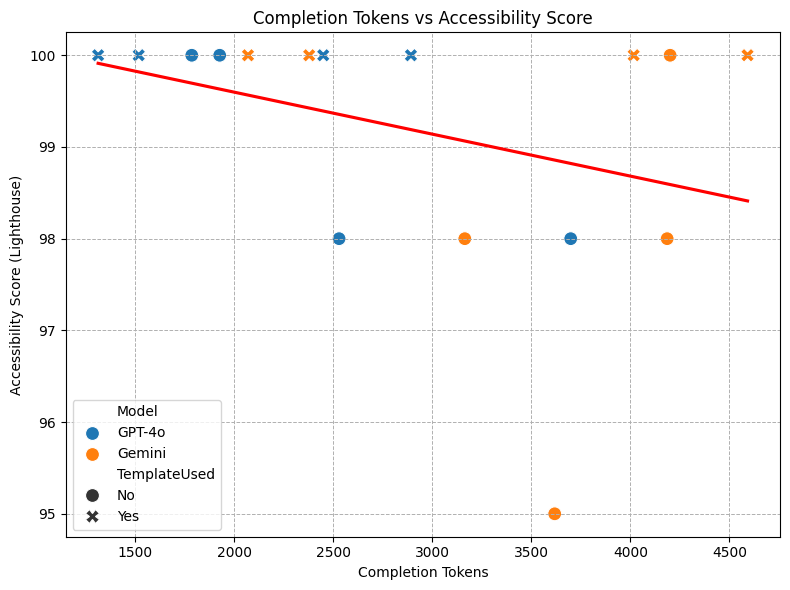

In [164]:
# Crear scatterplot
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='CompletionTokens', 
    y='AccessibilityScore', 
    hue='Model', 
    style='TemplateUsed', 
    data=df,
    s=100
)

# Añadir línea de tendencia (regresión lineal)
sns.regplot(
    x='CompletionTokens', 
    y='AccessibilityScore', 
    data=df, 
    scatter=False, 
    color='red',
    ci=None
)

plt.title('Completion Tokens vs Accessibility Score')
plt.xlabel('Completion Tokens')
plt.ylabel('Accessibility Score (Lighthouse)')
plt.grid(linestyle='--', linewidth=0.7)
plt.tight_layout()

# Guardar imagen
plt.savefig('figures/scatter_completiontokens_vs_accessibility.jpg', dpi=300)
plt.show()

#### 2.2 Tokens usados vs Accessibility Score

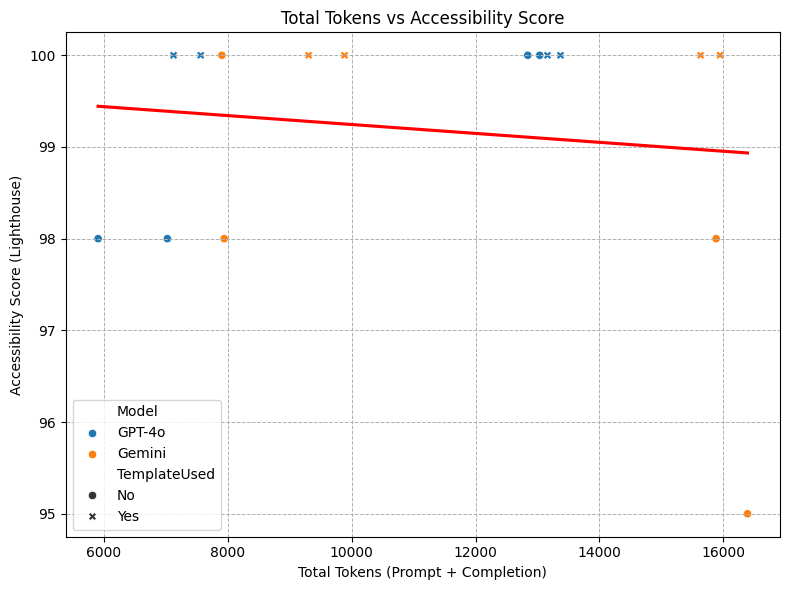

In [155]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='TotalTokens', y='AccessibilityScore', hue=df['Model'], style=df['TemplateUsed'], data=df)
sns.regplot(x='TotalTokens', y='AccessibilityScore', data=df, scatter=False, color='red', ci=None)
plt.title('Total Tokens vs Accessibility Score')
plt.xlabel('Total Tokens (Prompt + Completion)')
plt.ylabel('Accessibility Score (Lighthouse)')
plt.grid(linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig('figures/scatter_tokens_vs_accessibility_with_line.jpg', dpi=300)
plt.show()


#### 2.3 WAVE Errors vs Accessibility Score

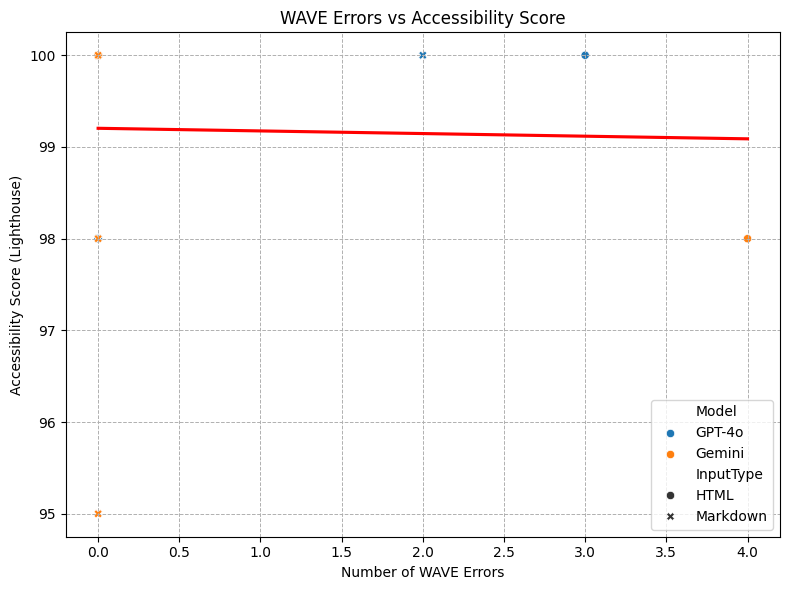

In [156]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='WAVEErrors', y='AccessibilityScore', hue=df['Model'], style=df['InputType'], data=df)
sns.regplot(x='WAVEErrors', y='AccessibilityScore', data=df, scatter=False, color='red', ci=None)
plt.title('WAVE Errors vs Accessibility Score')
plt.xlabel('Number of WAVE Errors')
plt.ylabel('Accessibility Score (Lighthouse)')
plt.grid(linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.savefig('figures/scatter_waveerrors_vs_accessibility_with_line.jpg', dpi=300)
plt.show()



### 3. Bar charts — Comparaciones antes y después

#### 3.1 Errores WAVE Original vs Mejorados (por sitio)

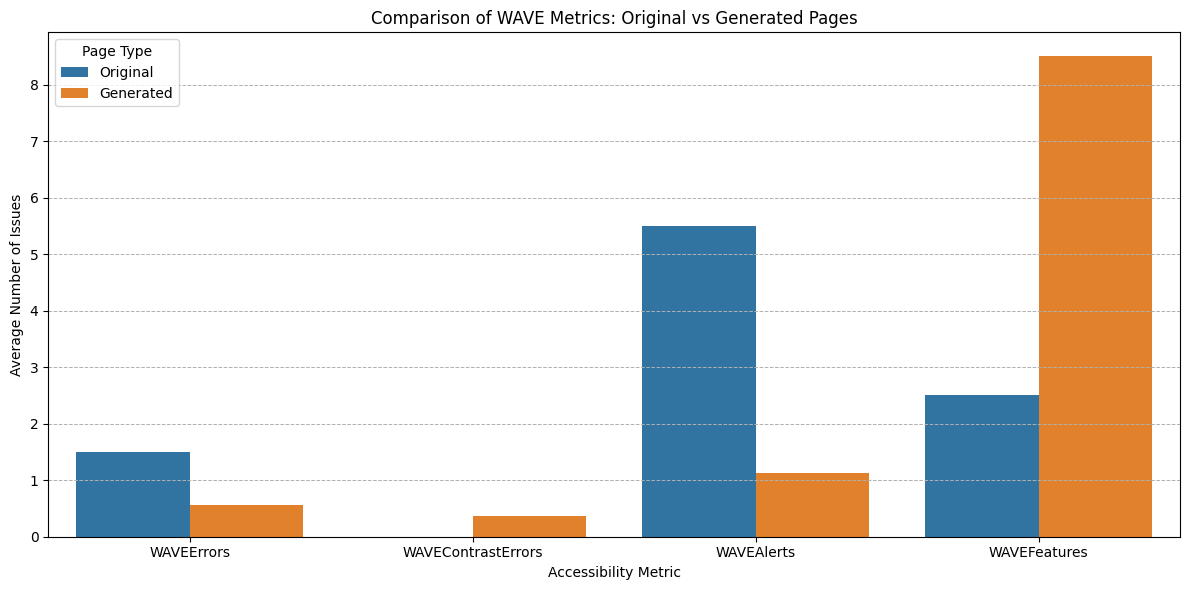

In [157]:
# Datos originales de los sitios (según tu reporte inicial)
original_metrics = {
    'Blocks': {'WAVEErrors': 0, 'WAVEContrastErrors': 0, 'WAVEAlerts': 8, 'WAVEFeatures': 4},
    'Forms': {'WAVEErrors': 3, 'WAVEContrastErrors': 0, 'WAVEAlerts': 3, 'WAVEFeatures': 1}
}

# Promedios de las métricas generadas
generated_metrics = df.groupby('Site')[['WAVEErrors', 'WAVEContrastErrors', 'WAVEAlerts', 'WAVEFeatures']].mean()

# Estructurar los datos para graficar
data = []
sites = ['Blocks', 'Forms']
metrics = ['WAVEErrors', 'WAVEContrastErrors', 'WAVEAlerts', 'WAVEFeatures']

for site in sites:
    for metric in metrics:
        data.append({
            'Site': site,
            'Metric': metric,
            'Type': 'Original',
            'Value': original_metrics[site][metric]
        })
        data.append({
            'Site': site,
            'Metric': metric,
            'Type': 'Generated',
            'Value': generated_metrics.loc[site, metric]
        })

compare_df = pd.DataFrame(data)

# Gráfica
plt.figure(figsize=(12,6))
sns.barplot(x='Metric', y='Value', hue='Type', data=compare_df, errorbar=None)
plt.title('Comparison of WAVE Metrics: Original vs Generated Pages')
plt.ylabel('Average Number of Issues')
plt.xlabel('Accessibility Metric')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.legend(title='Page Type')
plt.tight_layout()
plt.savefig('figures/bar_wave_metrics_comparison.jpg', dpi=300)
plt.show()
